## Introduction to Ray Train

This notebook will walk you through the basics of distributed training with Ray Train and PyTorch.

<div class="alert alert-block alert-info">

<b> Here is the roadmap for this notebook:</b>

<ul>
    <li><b>Part 1:</b> Single GPU PyTorch</li>
    <li><b>Part 2:</b> Overview of the training loop in Ray Train</li>
    <li><b>Part 3:</b> Migrating the model to Ray Train</li>
    <li><b>Part 4:</b> Migrating the dataset to Ray Train</li>
    <li><b>Part 5:</b> Reporting metrics and checkpoints</li>
    <li><b>Part 6:</b> Launching the distributed training job</li>
    <li><b>Part 7:</b> Accessing training results</li>
    <li><b>Part 8:</b> Ray Train in production </li>
</ul>
</div>

## Imports

In [4]:
import os   
import tempfile
from pathlib import Path
import datetime

import csv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torchmetrics
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision.models import resnet18
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor, Normalize, Compose

import ray
from ray.train import ScalingConfig, RunConfig
from ray.train.torch import TorchTrainer

## 1. Single GPU PyTorch

We will start by fitting a `ResNet18` model to an `MNIST` dataset.

Here is a diagram visualizing the single GPU training process:

<img src="https://anyscale-public-materials.s3.us-west-2.amazonaws.com/ray-ai-libraries/diagrams/single_gpu_pytorch_v3.png" width="800" >

At a high level, here is how our training loop in PyTorch looks like: 

In [5]:
def train_loop_torch(num_epochs: int = 2, batch_size: int = 128, local_path: str = "./checkpoints"):
    # Model, Loss, Optimizer
    criterion = CrossEntropyLoss()
    model = load_model_torch()
    optimizer = Adam(model.parameters(), lr=1e-5)

    # Initialize the metric 
    acc = torchmetrics.Accuracy(task="multiclass", num_classes=10).to("cuda")

    # Load the data loader
    data_loader = build_data_loader_torch(batch_size=batch_size)

    # Training loop
    for epoch in range(num_epochs):
        for images, labels in data_loader:
            # Move the data to the GPU
            images, labels = images.to("cuda"), labels.to("cuda")

            # Forward pass
            outputs = model(images)

            # Compute the loss
            loss = criterion(outputs, labels)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()

            # Update the weights
            optimizer.step()

            # Update the metric
            acc(outputs, labels)
        
        # Report the metrics
        metrics = report_metrics_torch(loss=loss, accuracy=acc.compute(), epoch=epoch)
        
        # Reset the metric
        acc.reset()

        # Save the checkpoint and metrics
        Path(local_path).mkdir(parents=True, exist_ok=True)
        save_checkpoint_and_metrics_torch(metrics=metrics, model=model, local_path=local_path)


We first start by defining how to build and load our model on a single GPU.

In [6]:
def build_resnet18():
    model = resnet18(num_classes=10)
    model.conv1 = torch.nn.Conv2d(
        in_channels=1, # grayscale MNIST images
        out_channels=64,
        kernel_size=(7, 7),
        stride=(2, 2),
        padding=(3, 3),
        bias=False,
    )
    return model


def load_model_torch() -> torch.nn.Module:
    model = build_resnet18()
    # Move to the single GPU device
    model.to("cuda")
    return model

Here is our dataset

In [7]:
dataset = MNIST(root="./data", train=True, download=True)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9.91M/9.91M [00:00<00:00, 27.2MB/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28.9k/28.9k [00:00<00:00, 1.44MB/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.65M/1.65M [00:00<00:00, 12.8MB/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4.54k/4.54k [00:00<00:00, 10.1MB/s]


Let's display the first 10 images, with the corresponding labels:

/data/archive/ray/course/intro2ray/.venv/lib/python3.12/site-packages/torchvision/datasets/mnist.py:76: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/data/archive/ray/course/intro2ray/.venv/lib/python3.12/site-packages/torchvision/datasets/mnist.py:66: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


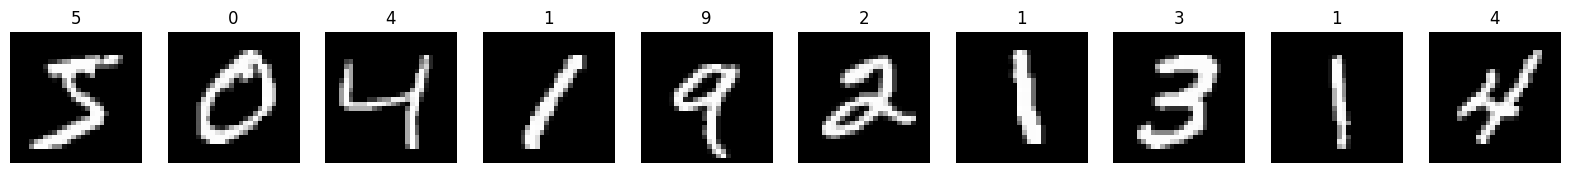

In [8]:
fig, axs = plt.subplots(1, 10, figsize=(20, 2))

for i in range(10):
    axs[i].imshow(dataset.train_data[i], cmap="gray")
    axs[i].axis("off")
    axs[i].set_title(dataset.train_labels[i].item())

We will also define a data loader to load our data in batches and apply transformations.

In [9]:
def build_data_loader_torch(batch_size: int) -> DataLoader:
    transform = Compose([ToTensor(), Normalize((0.5,), (0.5,))])
    dataset = MNIST(root="./data", train=True, download=True, transform=transform)
    train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    return train_loader

We will compute and report metrics via a simple print statement.

In [10]:
def report_metrics_torch(loss: torch.Tensor, accuracy: torch.Tensor, epoch: int) -> None:
    metrics = {"loss": loss.item(), "epoch": epoch, "accuracy": accuracy.item()}
    print(metrics)
    return metrics

To save the checkpoint we will make use of a local directory.

In [11]:
def save_checkpoint_and_metrics_torch(metrics: dict[str, float], model: torch.nn.Module, local_path: str) -> None:
    # Save the metrics
    with open(os.path.join(local_path, "metrics.csv"), "a") as f:
        writer = csv.writer(f)
        writer.writerow(metrics.values())

    # Save the model
    checkpoint_path = os.path.join(local_path, "model.pt")
    torch.save(model.state_dict(), checkpoint_path)

Now we can schedule the training loop on a single GPU

In [12]:
timestamp = datetime.datetime.now(datetime.UTC).strftime("%Y-%m-%d_%H-%M-%S")
local_path = f"/mnt/local_storage/single_gpu_mnist/torch_{timestamp}/"

train_loop_torch(
    num_epochs=2, 
    local_path=local_path
)

{'loss': 0.17373433709144592, 'epoch': 0, 'accuracy': 0.80931156873703}
{'loss': 0.12736190855503082, 'epoch': 1, 'accuracy': 0.9513054490089417}


Let's inspect the produced checkpoints and metrics

In [13]:
!ls -l {local_path}

total 43732
-rw-rw-r-- 1 map map       82 Apr 10 09:18 metrics.csv
-rw-rw-r-- 1 map map 44773570 Apr 10 09:18 model.pt


In [14]:
metrics = pd.read_csv(
    os.path.join(local_path, "metrics.csv"),
    header=None,
    names=["loss", "epoch", "accuracy"],
)

metrics

,loss,epoch,accuracy
0,0.173734,0,0.809312
1,0.127362,1,0.951305


We can also load our produced model checkpoint

In [15]:
loaded_model = build_resnet18()
loaded_model.load_state_dict(torch.load(os.path.join(local_path, "model.pt")))
loaded_model.eval()

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

We can the proceed to generate predictions on the first 10 images of the MNIST dataset.

/data/archive/ray/course/intro2ray/.venv/lib/python3.12/site-packages/torchvision/datasets/mnist.py:76: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


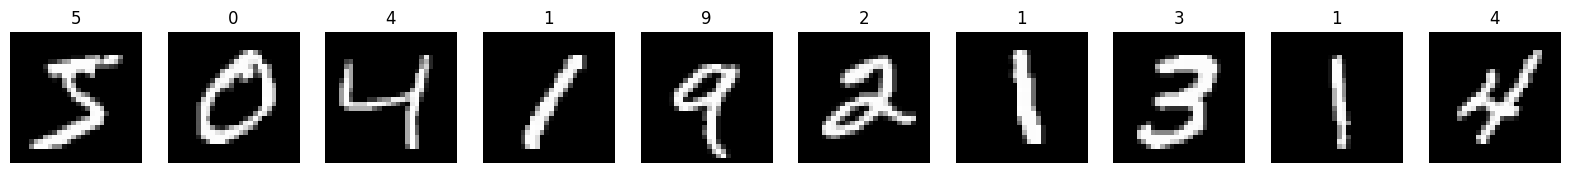

In [16]:
fig, axs = plt.subplots(1, 10, figsize=(20, 2))
for i in range(10):
    axs[i].imshow(dataset.train_data[i], cmap="gray")
    axs[i].axis("off")
    with torch.no_grad():
        normalized = Normalize((0.5,), (0.5,))(ToTensor()(dataset[i][0]))
        prediction = loaded_model(normalized.unsqueeze(0)).argmax()
    axs[i].set_title(prediction.item())

## Distributed Data Parallel Training with Ray Train and PyTorch

Let's now consider the case where we have a very large dataset of images that would take a long time to train on a single GPU. 

We would now like to scale this training job to run on multiple GPUs. 

Here is a diagram visualizing the desired distributed data-parallel training process:

<img src="https://anyscale-public-materials.s3.us-west-2.amazonaws.com/ray-ai-libraries/diagrams/multi_gpu_pytorch_v4.png" width="1000" >




## 2. Overview of the training loop in Ray Train

Let's see how this data-parallel training loop will look like with Ray Train and PyTorch.



In [ ]:
def train_loop_ray_train(config: dict):  # pass in hyperparameters in config
    criterion = CrossEntropyLoss()
    # Use Ray Train to wrap the model with DistributedDataParallel
    model = load_model_ray_train()
    optimizer = Adam(model.parameters(), lr=1e-5)
    
    # Calculate the batch size for each worker
    global_batch_size = config["global_batch_size"]
    batch_size = global_batch_size // ray.train.get_context().get_world_size()
    # Use Ray Train to wrap the data loader as a DistributedSampler
    data_loader = build_data_loader_ray_train(batch_size=batch_size) 
    
    acc = torchmetrics.Accuracy(task="multiclass", num_classes=10).to(model.device)

    for epoch in range(config["num_epochs"]):
        # Ensure data is on the correct device
        data_loader.sampler.set_epoch(epoch)

        for images, labels in data_loader: # images, labels are now sharded across the workers
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward() # gradients are now accumulated across the workers
            optimizer.step()
            acc(outputs, labels)

        accuracy = acc.compute() # accuracy is now aggregated across the workers

        # Use Ray Train to report metrics
        metrics = print_metrics_ray_train(loss, accuracy, epoch)

        # Use Ray Train to save checkpoint and metrics
        save_checkpoint_and_metrics_ray_train(model, metrics)
        acc.reset() 

### Configure scale and GPUs
Outside of our training function, we create a `ScalingConfig` object to configure:

- `num_workers`: The number of distributed training worker processes.
- `use_gpu`: Whether each worker should use a GPU (or CPU).


See [docs on configuring scale and GPUs](https://docs.ray.io/en/latest/train/user-guides/using-gpus.html) for more details.

In [39]:
scaling_config = ScalingConfig(num_workers=2, use_gpu=True)

Here is a high-level architecture of how Ray Train works:

<img src="https://docs.ray.io/en/latest/_images/overview.png" width=600>

Here are some key points:
- The scaling config specifies the number of training workers.
- A trainer actor process is launched that oversees the training workers.

Next we will dive deep in to the steps:
- Migrating the model to Ray Train
- Migrating the dataset to Ray Train
- Reporting metrics and checkpoints
- Launching a training job


## 3. Migrating the model to Ray Train

Use the `ray.train.torch.prepare_model()` utility function to:

- Automatically move your model to the correct device.
- Wrap the model in pytorch's `DistributedDataParallel`.

To learn more about the `prepare_model()` function, see the [API reference](https://docs.ray.io/en/latest/train/api/doc/ray.train.torch.prepare_model.html#ray-train-torch-prepare-model).

In [40]:
def load_model_ray_train() -> torch.nn.Module:
    model = build_resnet18()
    model = ray.train.torch.prepare_model(model) # Instead of model = model.to("cuda")
    return model

## 4. Migrating the dataset to Ray Train

Use the `ray.train.torch.prepare_data_loader()` utility function, to:

- Automatically moves the batches to the right device.
- Wrap the data loader with pytorch's `DistributedSampler`.

To learn more about the `prepare_data_loader()` function, see the [API reference](https://docs.ray.io/en/latest/train/api/doc/ray.train.torch.prepare_data_loader.html#ray-train-torch-prepare-data-loader).

In [41]:
def build_data_loader_ray_train(batch_size: int) -> DataLoader:
    transform = Compose([ToTensor(), Normalize((0.5,), (0.5,))])
    train_data = MNIST(root="./data", train=True, download=True, transform=transform)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)

    # Add DistributedSampler to the DataLoader
    train_loader = ray.train.torch.prepare_data_loader(train_loader)
    return train_loader

<div class="alert alert-block alert-warning">
<b> Note</b> that this step isn’t necessary if you are integrating your Ray Train implementaiton with Ray Data.
</div>

## 5. Reporting checkpoints and metrics

To monitor progress, we can continue to print/log metrics as before. This time we chose to only do so for the first worker.

In [ ]:
def print_metrics_ray_train(
    loss: torch.Tensor, accuracy: torch.Tensor, epoch: int
) -> None:
    metrics = {"loss": loss.item(), "accuracy": accuracy.item(), "epoch": epoch}
    if ray.train.get_context().get_world_rank() == 0:
        print(metrics)
    return metrics

we will report intermediate metrics and checkpoints using the `ray.train.report` utility function.

In [ ]:
def save_checkpoint_and_metrics_ray_train(
    model: torch.nn.Module, metrics: dict[str, float]
) -> None:
    with tempfile.TemporaryDirectory() as temp_checkpoint_dir:
        torch.save(
            model.module.state_dict(),  # note the .module to unwrap the DistributedDataParallel
            os.path.join(temp_checkpoint_dir, "model.pt"),
        )
        ray.train.report(  # use ray.train.report to save the metrics and checkpoint
            metrics,  # train.report will only save worker rank 0's metrics
            checkpoint=ray.train.Checkpoint.from_directory(temp_checkpoint_dir),
        )

Here is the lifecycle of a checkpoint from being created using a local path to being uploaded to persistent storage.

<img src="https://docs.ray.io/en/latest/_images/checkpoint_lifecycle.png" width=800>


Given it is the same model across all workers, we can instead only build the checkpoint on worker of rank 0. Note that we will still need to call `ray.train.report` on all workers to ensure that the training loop is synchronized.

In [ ]:
def save_checkpoint_and_metrics_ray_train(
    model: torch.nn.Module, metrics: dict[str, float]
) -> None:
    with tempfile.TemporaryDirectory() as temp_checkpoint_dir:
        checkpoint = None
        if ray.train.get_context().get_world_rank() == 0:
            torch.save(
                model.module.state_dict(), os.path.join(temp_checkpoint_dir, "model.pt")
            )
            checkpoint = ray.train.Checkpoint.from_directory(temp_checkpoint_dir)

        ray.train.report(
            metrics,
            checkpoint=checkpoint,
        )

For an in-depth guide on saving checkpoints and metrics, see the [docs](https://docs.ray.io/en/latest/train/user-guides/checkpoints.html).

## 6. Launching the distributed training job

Here is the desired data-parallel training diagram, but now using Ray Train.

<img src="https://anyscale-public-materials.s3.us-west-2.amazonaws.com/ray-ai-libraries/diagrams/multi_gpu_pytorch_annotated_v5.png" width="1000" >

Let's proceed to launch the distributed training job.

### Configure persistent storage
Create a `RunConfig` object to specify the path where results (including checkpoints and artifacts) will be saved.


In [ ]:
storage_path = "/mnt/cluster_storage/ray-summit-2024-training/"
run_config = RunConfig(storage_path=storage_path, name="distributed-mnist-resnet18")

We can now launch a distributed training job with a `TorchTrainer`.

In [ ]:
trainer = TorchTrainer(
    train_loop_ray_train,
    scaling_config=scaling_config,
    run_config=run_config,
    train_loop_config={"num_epochs": 2, "global_batch_size": 128},
)


Calling `trainer.fit()` will start the run and block until it completes.

In [ ]:
result = trainer.fit()

## 7. Access the training results

After training completes, a `Result` object is returned which contains information about the training run, including the metrics and checkpoints reported during training.

In [ ]:
result

We can check the metrics produced by the training job.

In [ ]:
result.metrics_dataframe

We can also take the latest checkpoint and load it to inspect the model.

In [ ]:
ckpt = result.checkpoint
with ckpt.as_directory() as ckpt_dir:
    model_path = os.path.join(ckpt_dir, "model.pt")
    loaded_model_ray_train = build_resnet18()
    state_dict = torch.load(model_path, map_location=torch.device('cpu'), weights_only=True)
    loaded_model_ray_train.load_state_dict(state_dict)
    loaded_model_ray_train.eval()

loaded_model_ray_train

To learn more about the training results, see this [docs](https://docs.ray.io/en/latest/train/user-guides/results.html) on inspecting the training results.

We can then proceed to generate predictions using the loaded model:

In [ ]:
fig, axs = plt.subplots(1, 10, figsize=(20, 2))

for i in range(10):
    axs[i].imshow(dataset.train_data[i], cmap="gray")
    axs[i].axis("off")
    with torch.no_grad():
        normalized = Normalize((0.5,), (0.5,))(ToTensor()(dataset[i][0]))
        prediction = loaded_model_ray_train(normalized.unsqueeze(0)).argmax()
    axs[i].set_title(prediction.item())
    

<div class="alert alert-block alert-info">

### Activity: Update the training loop to compute AUROC

1. Update the training loop `train_loop_ray_train` to compute the AUROC metric.
2. Update the `print_metrics_ray_train` function to include the AUROC metric.
3. Save the AUROC metric in the `save_checkpoint_and_metrics_ray_train` function.

Use the following code snippets to guide you:

```python
# Hint: Update the print function to include AUROC
def print_metrics_ray_train(...):
    ...

def train_loop_ray_train(config):
    # Hint: Update the training loop to compute AUROC

trainer = TorchTrainer(
    train_loop_ray_train,
    scaling_config=scaling_config,
    run_config=run_config,
    train_loop_config={"num_epochs": 2, "global_batch_size": 128},
)
result = trainer.fit()
result.metrics_dataframe
```

</div>

In [ ]:
# Write your solution here


<div class="alert alert-block alert-info">

<details>

<summary> Click here to see the solution </summary>

```python
def print_metrics_ray_train(loss, accuracy, auroc):
    metrics = {
        "loss": loss.item(),
        "accuracy": accuracy.item(),
        "auroc": auroc.item(),
    }
    if ray.train.get_context().get_world_rank() == 0:
        print(
            f"Loss: {loss.item()}, Accuracy: {accuracy.item()}, AUROC: {auroc.item()}"
        )
    return metrics


def train_loop_ray_train(config):
    criterion = CrossEntropyLoss()
    model = load_model_ray_train()
    optimizer = Adam(model.parameters(), lr=1e-5)

    global_batch_size = config["global_batch_size"]
    batch_size = global_batch_size // ray.train.get_context().get_world_size()
    data_loader = build_data_loader_ray_train(batch_size=batch_size)

    acc = torchmetrics.Accuracy(task="multiclass", num_classes=10).to(model.device)
    # Add AUROC metric
    auroc = torchmetrics.AUROC(task="multiclass", num_classes=10).to(model.device)

    for epoch in range(config["num_epochs"]):
        data_loader.sampler.set_epoch(epoch)

        for images, labels in data_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            acc(outputs, labels)
            auroc(outputs, labels)

        metrics = print_metrics_ray_train(
            loss, acc.compute(), auroc.compute()
        )
        save_checkpoint_and_metrics_ray_train(model, metrics)
        acc.reset()
        auroc.reset()

trainer = TorchTrainer(
    train_loop_ray_train,
    scaling_config=scaling_config,
    run_config=run_config,
    train_loop_config={"num_epochs": 2, "global_batch_size": 128},
)
result = trainer.fit()
print(result.metrics_dataframe)
```

</details>

## 8. Ray Train in Production

Here are some use-cases of using Ray Train in production:
1. Canva uses Ray Train + Ray Data to cut down Stable Diffusion training costs by 3.7x. Read this [Anyscale blog post here](https://www.anyscale.com/blog/scalable-and-cost-efficient-stable-diffusion-pre-training-with-ray) and the [Canva  case study here](https://www.anyscale.com/resources/case-study/how-canva-built-a-modern-ai-platform-using-anyscale)
2. Anyscale uses Ray Train + Deepspeed to finetune language models. Read more [here](https://github.com/ray-project/ray/tree/master/doc/source/templates/04_finetuning_llms_with_deepspeed).


In [ ]:
# Run this cell for file cleanup 
!rm -rf /mnt/cluster_storage/single_gpu_mnist